In [2]:
import numpy as np
import scipy.io as sio
import re  

def load_mat(path):
    return sio.loadmat(path, simplify_cells=True)

def find_movement_rep(mat_struct, movement, rep=1, data_field="DAQ_DATA"):
    if not isinstance(movement, str) or len(movement.strip()) == 0:
        raise ValueError("movement debe ser un string no vacío, ej: 'hook', 'handopen'...")

    mv = movement.strip().lower()
    rep_str = str(rep)

    keys = [k for k in mat_struct.keys() if not k.startswith("__")]
    if not keys:
        raise KeyError("El .mat no contiene claves útiles (solo metadatos).")

    def norm(s):
        return re.sub(r"[\s\-]+", "", s.lower())

    mv_norm = norm(mv)

    mv_cand = [k for k in keys if mv_norm in norm(k)]
    if not mv_cand:
        msg = f"No encuentro ninguna clave relacionada con '{movement}'. "
        msg += f"Keys disponibles (primeras 50): {keys[:50]}"
        raise KeyError(msg)

    def rep_score(k):
        kl = norm(k)
        score = 0
        if re.search(rf"_{rep_str}\b", k):         # exact "_1"
            score += 5
        if kl.endswith(rep_str):                    # termina en 1
            score += 4
        if re.search(rf"rep{rep_str}\b", kl):       # contiene "rep1"
            score += 4
        if re.search(rf"\b{rep_str}\b", k):         # aparece como token
            score += 2
        return score

    mv_cand_sorted = sorted(mv_cand, key=lambda k: rep_score(k), reverse=True)

    for k in mv_cand_sorted:
        obj = mat_struct[k]

        if isinstance(obj, np.ndarray) and obj.ndim == 2:
            return obj, k

        if isinstance(obj, dict):
            if data_field in obj:
                X = np.array(obj[data_field])
                if X.ndim == 2:
                    return X, f"{k}.{data_field}"

            for kk in obj.keys():
                kkl = kk.lower()
                if ("daq" in kkl and "data" in kkl) or (data_field.lower() in kkl):
                    X = np.array(obj[kk])
                    if isinstance(X, np.ndarray) and X.ndim == 2:
                        return X, f"{k}.{kk}"

            for kk in obj.keys():
                X = np.array(obj[kk])
                if isinstance(X, np.ndarray) and X.ndim == 2:
                    return X, f"{k}.{kk}"

    raise TypeError(
        f"Encontré claves para '{movement}' (ej: {mv_cand_sorted[:5]}), "
        f"pero no pude extraer una matriz EMG 2D (samples x channels)."
    )

# --- USO ---
path_post = r"C:/Users/34648/Desktop/Clases/4_GITT/TFG/OPENICPSR/TR2_preTMR_32chanEMG.mat"
mat_post = load_mat(path_post)

X, key = find_movement_rep(mat_post, movement="handopen", rep=2)
fs = 1000  # Hz

print("Campo encontrado:", key)
print("Shape:", X.shape, "(samples x channels)")


Campo encontrado: HandOpen_2.DAQ_DATA
Shape: (2001, 32) (samples x channels)


In [3]:
from scipy.signal import butter, filtfilt, iirnotch

def bandpass(x, fs, lo=20, hi=450, order=4):
    b, a = butter(order, [lo/(fs/2), hi/(fs/2)], btype="band")
    return filtfilt(b, a, x, axis=0)

def notch(x, fs, f0=50, Q=30):
    b, a = iirnotch(w0=f0/(fs/2), Q=Q)
    return filtfilt(b, a, x, axis=0)

def rms_envelope(x, fs, win_ms=100):
    win = int(round(win_ms * fs / 1000))
    win = max(win, 1)
    # RMS por convolución: mean(x^2) en ventana
    x2 = x**2
    kernel = np.ones((win, 1)) / win
    mean_x2 = np.apply_along_axis(lambda v: np.convolve(v, kernel[:,0], mode="same"), 0, x2)
    return np.sqrt(mean_x2)

# --- pipeline ---
Xf = bandpass(X, fs)
Xf = notch(Xf, fs, f0=50)   # cambia a 60 si procede
env = rms_envelope(Xf, fs, win_ms=100)  # samples x channels


In [12]:
def detect_onset_offset(env, fs, k=2.0, min_dur_ms=150):
    """
    env: (samples x channels) RMS
    devuelve onset/offset en muestras y segundos usando umbral sobre RMS media.
    """
    g = env.mean(axis=1)  # RMS global
    # baseline: primer 20% del ensayo (ajusta si tu rep está recortada distinto)
    n0 = int(0.2 * len(g))
    base = g[:n0]
    thr = base.mean() + k * base.std()

    above = g > thr
    # limpia activaciones cortas
    min_len = int(min_dur_ms * fs / 1000)
    # encuentra segmentos
    idx = np.where(above)[0]
    if len(idx) == 0:
        return None, None, thr, g

    # agrupa índices contiguos
    splits = np.where(np.diff(idx) > 1)[0] + 1
    groups = np.split(idx, splits)
    # filtra por duración
    groups = [gr for gr in groups if len(gr) >= min_len]
    if not groups:
        return None, None, thr, g

    # el segmento principal = el más largo
    gr = max(groups, key=len)
    onset, offset = gr[0], gr[-1]
    return onset, offset, thr, g

on, off, thr, g = detect_onset_offset(env, fs, k=1.2)

print("thr:", thr)
print("on/off (samples):", on, off)
print("on/off (sec):", on/fs, off/fs)


thr: 0.536010274721858
on/off (samples): None None


TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

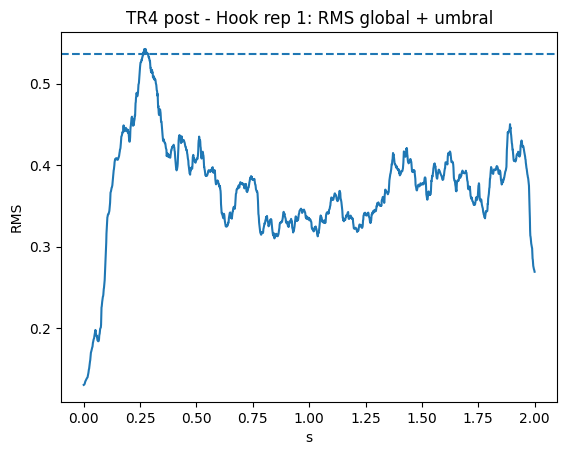

In [13]:
import matplotlib.pyplot as plt

t = np.arange(len(g)) / fs
plt.figure()
plt.plot(t, g)
plt.axhline(thr, linestyle="--")
if on is not None:
    plt.axvline(on/fs, linestyle="--")
    plt.axvline(off/fs, linestyle="--")
plt.title("TR4 post - Hook rep 1: RMS global + umbral")
plt.xlabel("s")
plt.ylabel("RMS")
plt.show()


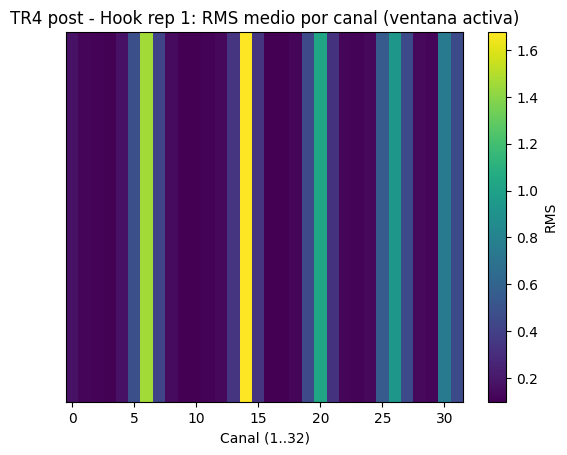

In [14]:
if on is None:
    on, off = 0, len(env)-1


feat = env[on:off].mean(axis=0)  # (32,)

plt.figure()
plt.imshow(feat.reshape(1, -1), aspect="auto")
plt.title("TR4 post - Hook rep 1: RMS medio por canal (ventana activa)")
plt.xlabel("Canal (1..32)")
plt.yticks([])
plt.colorbar(label="RMS")
plt.show()


In [10]:
import numpy as np
import scipy.io as sio
from scipy.signal import butter, filtfilt
from sklearn.decomposition import FastICA
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score

# ====== 1) CARGA ======
def load_mat(path):
    return sio.loadmat(path, simplify_cells=True)

# ====== 2) FIND MOVEMENT/REP POR CLAVES (estilo aux_func.py) ======
import re

def find_movement_rep_by_keys(mat_struct, movement, rep=1, data_field="DAQ_DATA"):
    """
    Busca en las KEYS del .mat algo tipo:
      HandOpen_2.DAQ_DATA  (o HandOpen_2 -> dict con DAQ_DATA)
    Devuelve X (samples x channels).
    """
    mv = movement.strip()
    rep_str = str(rep)

    keys = [k for k in mat_struct.keys() if not k.startswith("__")]
    if not keys:
        raise KeyError("El .mat no contiene claves útiles (solo metadatos).")

    def norm(s):
        return re.sub(r"[\s\-]+", "", s.lower())

    mv_norm = norm(mv)

    # 1) candidatos por movimiento en el nombre de key
    mv_cand = [k for k in keys if mv_norm in norm(k)]
    if not mv_cand:
        raise KeyError(f"No encuentro ninguna key relacionada con '{movement}'. "
                       f"Ejemplos de keys: {keys[:50]}")

    # 2) prioriza los que contengan rep
    def rep_score(k):
        kl = norm(k)
        score = 0
        if re.search(rf"_{rep_str}\b", k):  # "_1"
            score += 5
        if kl.endswith(rep_str):
            score += 4
        if re.search(rf"rep{rep_str}\b", kl):
            score += 4
        if re.search(rf"\b{rep_str}\b", k):
            score += 2
        return score

    mv_cand_sorted = sorted(mv_cand, key=rep_score, reverse=True)

    for k in mv_cand_sorted:
        obj = mat_struct[k]

        # Caso A: ya es una matriz 2D
        if isinstance(obj, np.ndarray) and obj.ndim == 2:
            X = np.asarray(obj, dtype=float)
            if X.shape[0] < X.shape[1]:
                X = X.T
            return X, k

        # Caso B: es dict con DAQ_DATA
        if isinstance(obj, dict):
            if data_field in obj:
                X = np.asarray(obj[data_field], dtype=float)
                if X.ndim == 2:
                    if X.shape[0] < X.shape[1]:
                        X = X.T
                    return X, f"{k}.{data_field}"

            # fallback: primer array 2D
            for kk, vv in obj.items():
                if isinstance(vv, np.ndarray) and vv.ndim == 2:
                    X = np.asarray(vv, dtype=float)
                    if X.shape[0] < X.shape[1]:
                        X = X.T
                    return X, f"{k}.{kk}"

    raise RuntimeError(f"Encontré keys para '{movement}' (ej: {mv_cand_sorted[:5]}), "
                       f"pero no pude extraer una matriz 2D.")

# ====== 3) PREPRO + RMS FEATURE ======
def bandpass(x, fs, lo=20, hi=450, order=4):
    b, a = butter(order, [lo/(fs/2), hi/(fs/2)], btype="band")
    return filtfilt(b, a, x, axis=0)

def rms_envelope(x, fs, win_ms=100):
    win = max(2, int(round(win_ms * fs / 1000)))
    x2 = x**2
    kernel = np.ones(win) / win
    out = np.zeros_like(x, dtype=float)
    for ch in range(x.shape[1]):
        out[:, ch] = np.sqrt(np.convolve(x2[:, ch], kernel, mode="same"))
    return out

def detect_onset_offset(env, fs, k=2.0, min_dur_ms=150):
    g = env.mean(axis=1)
    n0 = int(0.2 * len(g))
    base = g[:max(n0, 1)]
    thr = base.mean() + k * (base.std() + 1e-12)

    above = g > thr
    if not np.any(above):
        return None, None

    idx = np.flatnonzero(above)
    splits = np.where(np.diff(idx) > 1)[0] + 1
    segments = np.split(idx, splits)

    min_len = int(round((min_dur_ms/1000) * fs))
    segments = [seg for seg in segments if len(seg) >= max(1, min_len)]
    if not segments:
        return None, None

    seg = max(segments, key=len)
    return int(seg[0]), int(seg[-1])

def extract_rms_feature(X, fs, rms_win_ms=100, onset_k=2.0):
    # filtra + zscore canal
    Xp = X - X.mean(axis=0, keepdims=True)
    Xp = bandpass(Xp, fs, 20, 450, order=4)
    Xz = (Xp - Xp.mean(axis=0, keepdims=True)) / (Xp.std(axis=0, keepdims=True) + 1e-9)

    env = rms_envelope(Xz, fs, win_ms=rms_win_ms)
    on, off = detect_onset_offset(env, fs, k=onset_k)
    if on is None or off is None or off <= on:
        on, off = 0, len(env)-1

    feat = env[on:off].mean(axis=0)
    return feat, Xz

# ====== 4) ICA CLEAN (keep ICs más energéticos) ======
def ica_clean(Xz, keep_ratio=0.35, seed=0):
    n = Xz.shape[1]
    ica = FastICA(
        n_components=n,
        whiten="unit-variance",
        random_state=seed,
        max_iter=2000,
        tol=1e-4,
    )
    S = ica.fit_transform(Xz)
    A = ica.mixing_
    mean_ = ica.mean_

    e = np.mean(S**2, axis=0)
    n_keep = max(1, int(round(keep_ratio * len(e))))
    keep = np.argsort(e)[::-1][:n_keep]
    X_clean = S[:, keep] @ A[:, keep].T + mean_
    return X_clean

# ====== 5) BUILD DATASET (baseline vs ICA) ======
def build_features(mat, movements, reps, fs, rms_win_ms=100, onset_k=2.0, keep_ratio=0.35, seed=0):
    X_base, X_ica, y = [], [], []
    for mv in movements:
        for rep in reps:
            X, where = find_movement_rep_by_keys(mat, mv, rep=rep, data_field="DAQ_DATA")

            feat0, Xz = extract_rms_feature(X, fs, rms_win_ms=rms_win_ms, onset_k=onset_k)
            Xc = ica_clean(Xz, keep_ratio=keep_ratio, seed=seed)

            envc = rms_envelope(Xc, fs, win_ms=rms_win_ms)
            on, off = detect_onset_offset(envc, fs, k=onset_k)
            if on is None or off is None or off <= on:
                on, off = 0, len(envc)-1
            feat1 = envc[on:off].mean(axis=0)

            X_base.append(feat0)
            X_ica.append(feat1)
            y.append(mv)

    return np.vstack(X_base), np.vstack(X_ica), np.array(y)

# ====== 6) EVALUACIÓN ======
def evaluate_cv(X, y, n_splits=5, seed=0):
    labels = np.unique(y)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("lda", LinearDiscriminantAnalysis())
    ])

    cm_sum = np.zeros((len(labels), len(labels)), dtype=int)
    accs = []

    for tr, te in skf.split(X, y):
        clf.fit(X[tr], y[tr])
        yp = clf.predict(X[te])
        accs.append(accuracy_score(y[te], yp))
        cm_sum += confusion_matrix(y[te], yp, labels=labels)

    return labels, cm_sum, float(np.mean(accs)), float(np.std(accs))

# =======================
#            MAIN
# =======================
MAT_PATH = "C:/Users/34648/Desktop/Clases/4_GITT/TFG/OPENICPSR/TR1_postTMR_32chanEMG.mat"
FS = 1000

# IMPORTANTE: usa nombres que EXISTAN como keys.
# En el PDF aparecen: "Hand open", "Power grip", "Hook grip", etc. :contentReference[oaicite:4]{index=4}
# En keys suele ser estilo: HandOpen_2.DAQ_DATA, HookGrip_1.DAQ_DATA...
MOVEMENTS = ["HandOpen", "PowerGrip", "WristFlexion"]  # <-- AJUSTA ESTO
REPS = range(1, 9)  # 8 repeticiones en el dataset :contentReference[oaicite:5]{index=5}

RMS_WIN_MS = 100
ONSET_K = 2.0
ICA_KEEP_RATIO = 0.35
SEED = 0

mat = load_mat(MAT_PATH)

# (opcional) imprime keys para que veas el naming real
keys = [k for k in mat.keys() if not k.startswith("__")]
print("[INFO] Ejemplos de keys:", keys[:40])

X0, X1, y = build_features(
    mat, MOVEMENTS, REPS, FS,
    rms_win_ms=RMS_WIN_MS,
    onset_k=ONSET_K,
    keep_ratio=ICA_KEEP_RATIO,
    seed=SEED
)

labels0, cm0, acc0, std0 = evaluate_cv(X0, y, n_splits=5, seed=0)
labels1, cm1, acc1, std1 = evaluate_cv(X1, y, n_splits=5, seed=0)

print("\n===== RESULTADOS =====")
print("Labels:", list(labels0))

print("\n--- Baseline (sin ICA) ---")
print(f"Accuracy CV: {acc0:.3f} ± {std0:.3f}")
print("Confusion matrix (sum folds):")
print(cm0)

print("\n--- ICA (reconstrucción parcial) ---")
print(f"Accuracy CV: {acc1:.3f} ± {std1:.3f}")
print("Confusion matrix (sum folds):")
print(cm1)

print("\nDelta accuracy (ICA - baseline):", (acc1 - acc0))


[INFO] Ejemplos de keys: ['FinePinchClosed_1', 'FinePinchClosed_2', 'FinePinchClosed_3', 'FinePinchClosed_4', 'FinePinchClosed_5', 'FinePinchClosed_6', 'FinePinchClosed_7', 'FinePinchClosed_8', 'FinePinchOpened_1', 'FinePinchOpened_2', 'FinePinchOpened_3', 'FinePinchOpened_4', 'FinePinchOpened_5', 'FinePinchOpened_6', 'FinePinchOpened_7', 'FinePinchOpened_8', 'HandOpen_1', 'HandOpen_2', 'HandOpen_3', 'HandOpen_4', 'HandOpen_5', 'HandOpen_6', 'HandOpen_7', 'HandOpen_8', 'Hook_1', 'Hook_2', 'Hook_3', 'Hook_4', 'Hook_5', 'Hook_6', 'Hook_7', 'Hook_8', 'IndexFlexion_1', 'IndexFlexion_2', 'IndexFlexion_3', 'IndexFlexion_4', 'IndexFlexion_5', 'IndexFlexion_6', 'IndexFlexion_7', 'IndexFlexion_8']


C:\Users\34648\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\34648\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
C:\Users\34648\AppData\Roaming\Python\Python311\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(



===== RESULTADOS =====
Labels: [np.str_('HandOpen'), np.str_('PowerGrip'), np.str_('WristFlexion')]

--- Baseline (sin ICA) ---
Accuracy CV: 0.530 ± 0.140
Confusion matrix (sum folds):
[[5 2 1]
 [3 3 2]
 [1 2 5]]

--- ICA (reconstrucción parcial) ---
Accuracy CV: 0.410 ± 0.111
Confusion matrix (sum folds):
[[2 3 3]
 [2 4 2]
 [3 1 4]]

Delta accuracy (ICA - baseline): -0.12000000000000005


[INFO] Trial extraído desde: PowerGrip_1.DAQ_DATA  shape: (2001, 32)


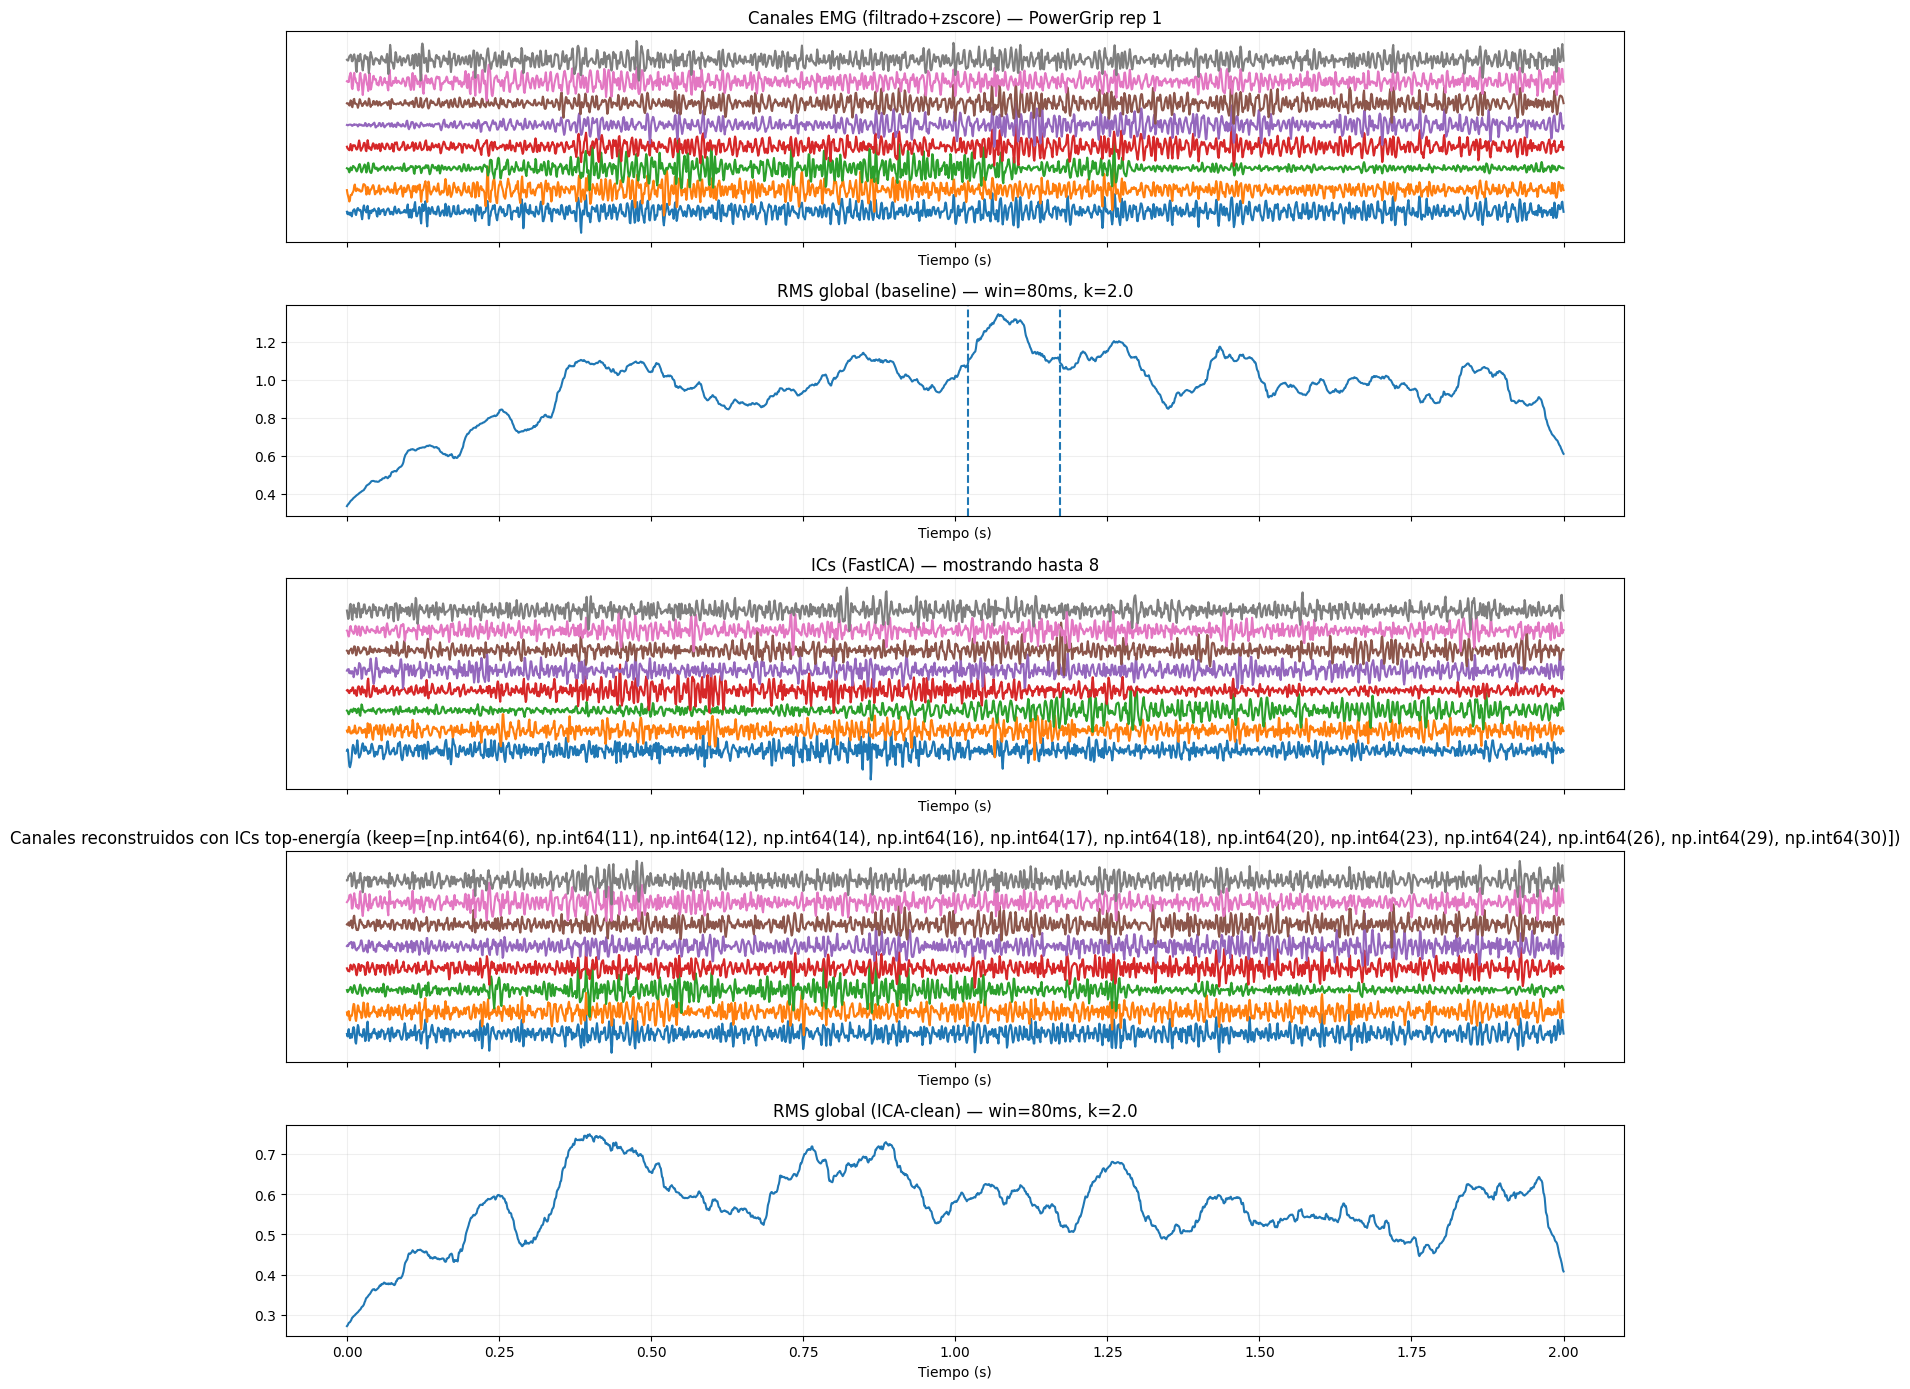

In [15]:
import numpy as np
import scipy.io as sio
import re
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.decomposition import FastICA

# =========================
# 1) LOAD + EXTRACT TRIAL
# =========================
def load_mat(path):
    return sio.loadmat(path, simplify_cells=True)

def find_movement_rep_by_keys(mat_struct, movement, rep=1, data_field="DAQ_DATA"):
    """
    Busca en KEYS algo tipo:
      HandOpen_2  (dict con DAQ_DATA)
      HandOpen_2.DAQ_DATA
      HandOpen2, HandOpen_rep2, etc (heurístico)
    Devuelve X (samples x channels).
    """
    mv = movement.strip()
    rep_str = str(rep)

    keys = [k for k in mat_struct.keys() if not k.startswith("__")]
    if not keys:
        raise KeyError("El .mat solo contiene metadatos.")

    def norm(s):
        return re.sub(r"[\s\-\.]+", "", s.lower())

    mv_norm = norm(mv)

    mv_cand = [k for k in keys if mv_norm in norm(k)]
    if not mv_cand:
        # enseña ejemplos para que ajustes MOVEMENT
        raise KeyError(f"No encuentro keys para '{movement}'. Ejemplos: {keys[:50]}")

    def rep_score(k):
        kl = norm(k)
        score = 0
        if re.search(rf"_{rep_str}\b", k): score += 6
        if kl.endswith(rep_str): score += 4
        if re.search(rf"rep{rep_str}\b", kl): score += 4
        if re.search(rf"\b{rep_str}\b", k): score += 2
        return score

    mv_cand = sorted(mv_cand, key=rep_score, reverse=True)

    for k in mv_cand:
        obj = mat_struct[k]

        if isinstance(obj, np.ndarray) and obj.ndim == 2:
            X = np.asarray(obj, dtype=float)
            if X.shape[0] < X.shape[1]:
                X = X.T
            return X, k

        if isinstance(obj, dict):
            if data_field in obj and isinstance(obj[data_field], np.ndarray) and obj[data_field].ndim == 2:
                X = np.asarray(obj[data_field], dtype=float)
                if X.shape[0] < X.shape[1]:
                    X = X.T
                return X, f"{k}.{data_field}"

            # fallback: primer array 2D grande
            for kk, vv in obj.items():
                if isinstance(vv, np.ndarray) and vv.ndim == 2 and max(vv.shape) > 300:
                    X = np.asarray(vv, dtype=float)
                    if X.shape[0] < X.shape[1]:
                        X = X.T
                    return X, f"{k}.{kk}"

    raise RuntimeError(f"Encontré keys para '{movement}' (ej: {mv_cand[:5]}), pero no pude extraer una matriz 2D.")

# =========================
# 2) PREPRO + RMS + ONSET
# =========================
def bandpass(x, fs, lo=20, hi=450, order=4):
    b, a = butter(order, [lo/(fs/2), hi/(fs/2)], btype="band")
    return filtfilt(b, a, x, axis=0)

def rms_envelope(x, fs, win_ms=100):
    win = max(2, int(round(win_ms * fs / 1000)))
    x2 = x**2
    kernel = np.ones(win) / win
    out = np.zeros_like(x, dtype=float)
    for ch in range(x.shape[1]):
        out[:, ch] = np.sqrt(np.convolve(x2[:, ch], kernel, mode="same"))
    return out

def detect_onset_offset(env, fs, k=2.0, min_dur_ms=150):
    g = env.mean(axis=1)
    n0 = int(0.2 * len(g))  # 20% inicial como baseline
    base = g[:max(n0, 1)]
    thr = base.mean() + k * (base.std() + 1e-12)

    above = g > thr
    if not np.any(above):
        return None, None, thr, g

    idx = np.flatnonzero(above)
    splits = np.where(np.diff(idx) > 1)[0] + 1
    segments = np.split(idx, splits)

    min_len = int(round((min_dur_ms/1000) * fs))
    segments = [seg for seg in segments if len(seg) >= max(1, min_len)]
    if not segments:
        return None, None, thr, g

    seg = max(segments, key=len)
    return int(seg[0]), int(seg[-1]), thr, g

# =========================
# 3) ICA CLEAN (para ver activación más clara)
# =========================
def ica_clean(Xz, keep_ratio=0.35, seed=0):
    n = Xz.shape[1]
    ica = FastICA(
        n_components=n,
        whiten="unit-variance",
        random_state=seed,
        max_iter=2000,
        tol=1e-4
    )
    S = ica.fit_transform(Xz)     # ICs
    A = ica.mixing_
    mean_ = ica.mean_

    # ICs más energéticos (heurística rápida)
    e = np.mean(S**2, axis=0)
    n_keep = max(1, int(round(keep_ratio * len(e))))
    keep = np.argsort(e)[::-1][:n_keep]
    keep = np.sort(keep)

    X_clean = S[:, keep] @ A[:, keep].T + mean_
    return S, X_clean, keep

# =========================
# 4) PLOTS BONITOS Y COMPARABLES
# =========================
def stacked_plot(ax, t, X, title, max_ch=8):
    """
    Plotea varias señales apiladas con offset para ver activaciones.
    """
    n = min(max_ch, X.shape[1])
    # normaliza cada canal para visual (no afecta análisis)
    Xn = X[:, :n] / (np.std(X[:, :n], axis=0, keepdims=True) + 1e-9)
    offset = np.arange(n) * 4.0
    ax.plot(t, Xn + offset)
    ax.set_title(title)
    ax.set_xlabel("Tiempo (s)")
    ax.set_yticks([])
    ax.grid(True, alpha=0.2)

def envelope_plot(ax, t, env_global, title, on=None, off=None):
    ax.plot(t, env_global)
    if on is not None and off is not None:
        ax.axvline(t[on], linestyle="--")
        ax.axvline(t[off], linestyle="--")
    ax.set_title(title)
    ax.set_xlabel("Tiempo (s)")
    ax.grid(True, alpha=0.2)

# =========================
# 5) MAIN
# =========================
MAT_PATH = "C:/Users/34648/Desktop/Clases/4_GITT/TFG/OPENICPSR/TR1_postTMR_32chanEMG.mat"
FS = 1000

MOVEMENT = "PowerGrip"   # EJ: "HandOpen" / "HookGrip" / "PowerGrip" ...
REP = 1

RMS_WIN_MS = 80         # 50-150 ms suele ir bien para ver picos
ONSET_K = 2.0
ICA_KEEP_RATIO = 0.4   # 0.25-0.5
SEED = 0

mat = load_mat(MAT_PATH)

X, where = find_movement_rep_by_keys(mat, MOVEMENT, rep=REP, data_field="DAQ_DATA")
print("[INFO] Trial extraído desde:", where, " shape:", X.shape)

# Prepro (para comparar: todo con el mismo Xz)
Xp = X - X.mean(axis=0, keepdims=True)
Xp = bandpass(Xp, FS, 20, 450, order=4)
Xz = (Xp - Xp.mean(axis=0, keepdims=True)) / (Xp.std(axis=0, keepdims=True) + 1e-9)

t = np.arange(Xz.shape[0]) / FS

# Baseline envelope + onset
env0 = rms_envelope(Xz, FS, win_ms=RMS_WIN_MS)
on0, off0, thr0, g0 = detect_onset_offset(env0, FS, k=ONSET_K)

# ICA: ICs + reconstrucción limpia
S, Xclean, keep = ica_clean(Xz, keep_ratio=ICA_KEEP_RATIO, seed=SEED)
env1 = rms_envelope(Xclean, FS, win_ms=RMS_WIN_MS)
on1, off1, thr1, g1 = detect_onset_offset(env1, FS, k=ONSET_K)

# ---- PLOTS ----
fig, axes = plt.subplots(5, 1, figsize=(14, 14), sharex=True)

stacked_plot(axes[0], t, Xz, f"Canales EMG (filtrado+zscore) — {MOVEMENT} rep {REP}", max_ch=8)
envelope_plot(axes[1], t, g0, f"RMS global (baseline) — win={RMS_WIN_MS}ms, k={ONSET_K}", on=on0, off=off0)

# ICs apilados (también normalizados para visualizar)
stacked_plot(axes[2], t, S, f"ICs (FastICA) — mostrando hasta 8", max_ch=8)

stacked_plot(axes[3], t, Xclean, f"Canales reconstruidos con ICs top-energía (keep={list(keep)})", max_ch=8)
envelope_plot(axes[4], t, g1, f"RMS global (ICA-clean) — win={RMS_WIN_MS}ms, k={ONSET_K}", on=on1, off=off1)

plt.tight_layout()
plt.show()
